# This notebook will explore data gathered from the US Airlines Sentiment Data Set

Summary of Data: Twitter responses towards US Airlines and the emotional state of each party.

Data Information:
Length of data set: 14,640
Columns in the data set:'tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'


In [99]:
# Importing Python modules
import numpy as np
import pandas as pd
import os
import seaborn as sns


# Ensure the Jupyter Notebooks fills the web browser
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
# Importing the dataset with pandas

# Changing the working directory to the raw data directory
os.chdir('/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/data/raw/US_Airline_Sentiment')
data_temp = pd.read_csv('Tweets.csv')

In [ ]:
data_temp.columns, data_temp.shape

In [3]:
# Minimalist appraoch to labelling the above data set: 
# Create a binary classification scheme = the headline has a "+" or "-" emotional response.
## Only collect the responses that gave a positive or negative emotional response from the airline

# data_pn = data_temp[data_temp.airline_sentiment != 'neutral'] 
# data_pn.airline_sentiment.unique(), data_pn.shape  

# Droping labels with nan and converting them
#data_temp.negativereason_confidence.dropna(how='all',inplace=True)
#data_temp['negativereason_confidence'] = data_temp.negativereason_confidence.round(0).astype(int)
#data_temp.negativereason_confidence.dropna(how='all',inplace=True)
#data_temp.negativereason_confidence.unique()


# # Gathering the text and labels

text = data_temp.text.copy(deep=True)
labels_confvalues = data_temp.negativereason_confidence
labels_confvalues.unique()
# # Pre-processing labels. Removing "inf" and nan
labels_confvalues.replace([np.inf, -np.inf], np.nan)
labels_confvalues.dropna()

# # Seperating the labels by seperating the confidence labels to be:
# # negative > 0.5, positive is <= 0.5
labels_confvalues.dropna(how='all', inplace=True)
labels = labels_confvalues.round(0).astype(int)
filter_text = labels.index
text = text[filter_text]

# Printing the number of each class:
print("The total number of tweets are:", labels.shape[0])
print("The number (out of 5000) of negative emotional headlines =", labels.shape[0] - labels.sum())
print("The number (out of 5000) of positive emotional headlines =", labels.sum())
print("The niave classification (1 class fit to all) is =", 1-2111.0/7397)

The total number of tweets are: 10522
The number (out of 5000) of negative emotional headlines = 3125
The number (out of 5000) of positive emotional headlines = 7397
The niave classification (1 class fit to all) is = 0.7146140327159659


In [4]:
# Forcing a balance dataset -- NIAVELY REMOVING POSITIVE TWEETS To BALANCE THE DATASET

## Splitting the Data into a Training, Validation, and Test Set
## Fractions are: Training = 80%, Validation = 10%, Test = 10 %

from sklearn.model_selection import train_test_split  


## For the time being, the following code forces the training, validation, and test data sets are balanced
num_pos_labels = labels.sum() # 1418 headlines
num_neg_labels = labels.shape[0] - num_pos_labels # 3582 headlines
num_pos_labels_2drop = num_pos_labels - num_neg_labels # 2164 headlines
print(num_pos_labels)
print(num_neg_labels)
print(num_pos_labels_2drop)
# cnt = 0

index_pos = labels[labels == 1].index
index_neg = labels[labels == 0].index
labels_temp_bal_pos = labels[index_pos[num_pos_labels_2drop:]]
labels_temp_bal_neg = labels[index_neg]

labels_temp_bal = labels_temp_bal_neg.combine(labels_temp_bal_pos, max, fill_value=0)

print("The total length of the label series = ", labels_temp_bal.shape)
print("The total number of positive labels =",labels_temp_bal.sum())
labels_temp_bal.loc[14638], labels.loc[14638]

## Ensuring we use the appropriate text from the balanced labeled series
labels_temp_bal_indices = labels_temp_bal.index
text_bal = text[labels_temp_bal_indices]

# cnt = 0
# for i in range(labels_temp_bal.shape[0]):
#     if labels_temp_bal.iloc[i] == 1 and cnt < (num_pos_labels_2drop+1):
#         labels_temp_bal[i].drop(inplace=True)
#         cnt += 1

# index_Label0 = data_temp_bal.index[data_temp_bal['BinaryEmoLabel'] == 0].tolist()


# Labels = data_temp.BinaryEmoLabel
# X_train, X_test, y_train, y_test = train_test_split(data_temp, Labels, test_size=0.2, random_state=1)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.5, random_state=1)

7397
3125
4272
The total length of the label series =  (6250,)
The total number of positive labels = 3125


## Pre-processing the text / headlines
#### Initially the steps which follow were inspired by the Medium Blog Posts:
#### https://towardsdatascience.com/sentiment-analysis-with-python-part-1-5ce197074184
#### https://towardsdatascience.com/sentiment-analysis-with-python-part-2-4f71e7bde59a
#### Written By: Aaron Kub

#### https://towardsdatascience.com/twitter-sentiment-analysis-classification-using-nltk-python-fa912578614c
#### Written By: Mohamed Afham ** Follwoing this scheme to begin the process

In [5]:
#Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#Data Preprocessing and Feature Engineering
from textblob import TextBlob
import re
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

#Model Selection and Validation
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score

In [6]:
## Combining all the above text pre-processing into one function 

def text_processing(headline):
    
    #Generating the list of words in the headline (hastags and other punctuations removed)
    def form_sentence(headline):
        headline_blob = TextBlob(headline)
        return ' '.join(headline_blob.words)
    new_headline = form_sentence(headline)
    
    #Removing stopwords and words with unusual symbols
    def no_user_alpha(headline):
        headline_list = [ele for ele in headline.split() if ele != 'user']
        clean_tokens = [t for t in headline_list if re.match(r'[^\W\d]*$', t)]
        clean_s = ' '.join(clean_tokens)
        clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
        return clean_mess
    no_punc_headline = no_user_alpha(new_headline)
    
    #Normalizing the words in headlines 
    def normalization(headline_list):
        lem = WordNetLemmatizer()
        normalized_headline = []
        for word in headline_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_headline.append(normalized_text)
        return normalized_headline
    
    
    return normalization(no_punc_headline)

In [7]:
def Int2EmotionConverter(IntEmo):
    """
    Converts the integer value of the emotion predicted to the emotions word in English
    """
    EmoWords = pd.DataFrame(['Happy','Sad'])
    return EmoWords.iloc[IntEmo][0]

In [8]:
# scikit-learn: Pre-defining a workflow of algorithm (Niave-Bayse Classifier)
pipeline = Pipeline([
    ('bow',CountVectorizer(analyzer=text_processing)),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),                      # integer counts to weighted TF-IDF scores
    ('classifier', MultinomialNB()),  # train on TF-IDF vectors w/ Naive Bayes classifier
])

In [9]:
### Trainiing Model ####
msg_train, msg_test, label_train, label_test = train_test_split(text_bal, labels_temp_bal, test_size=0.1)
pipeline.fit(msg_train,label_train)
predictions = pipeline.predict(msg_test)
print(classification_report(predictions,label_test))
print(confusion_matrix(predictions,label_test))
print(accuracy_score(predictions,label_test))
# What would the accuracy of the Training Data Set is we niavely set all labels to 0
print("The accuracy of labelling all headlines NEGATIVE is:",1-label_train.sum()/len(label_train))

print("This model's accuracy is better than the Niave assumption by:", accuracy_score(predictions,label_test) - 1+label_train.sum()/len(label_train)) 

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       286
           1       0.85      0.77      0.81       339

    accuracy                           0.80       625
   macro avg       0.80      0.81      0.80       625
weighted avg       0.81      0.80      0.80       625

[[240  46]
 [ 77 262]]
0.8032
The accuracy of labelling all headlines NEGATIVE is: 0.4992
This model's accuracy is better than the Niave assumption by: 0.30400000000000005


In [10]:
dummy_index = 90

temp_text = pd.Series([])
temp_text[0] = text.iloc[dummy_index]
type(temp_text)

out_temp = pipeline.predict(temp_text)
print("The sentence input was:\n",temp_text[0])
print("The emotional prediction was:", Int2EmotionConverter(out_temp[0]))

The sentence input was:
 @VirginAmerica I'd love to know what your policy is for damaged luggage.
The emotional prediction was: Happy


In [11]:
## Randomly print a positive review and a negative review -- MANUAL INSPECTION OF RESULTS

# Collecting all preditions
all_preds = pipeline.predict(text)

In [ ]:
# Gathering all indices for "positive" and "negative" reviews
pred_neg_indices = np.where(all_preds == 0)[0] # all_preds[all_preds == 0].index 
pred_pos_indices = np.where(all_preds == 1)[0] # all_preds[all_preds == 1].index

neg_index_ran = np.random.choice(pred_neg_indices,1)[0]
pos_index_ran = np.random.choice(pred_pos_indices,1)[0]
#print(neg_index_ran)
#print(pos_index_ran)

print("THIS IS THE SAD CASE!!")
# Printing the results of the negative text
print("The sentence input was:\n",text.iloc[neg_index_ran])
print("The emotional prediction was:", Int2EmotionConverter(all_preds[neg_index_ran]))
print("________________________")
print("THIS IS THE HAPPY CASE!!")
# Printing the results of the positive text
print("The sentence input was:\n",text.iloc[pos_index_ran])
print("The emotional prediction was:", Int2EmotionConverter(all_preds[pos_index_ran]))

## Now predicting the emotional sentiment (neg., pos.) given a user string

In [ ]:
temp_text = pd.Series([])
temp_text[0] = "I'm angry!"

out_temp = pipeline.predict(temp_text)
print("The sentence input was:\n",temp_text[0])
print("The emotional prediction was:", Int2EmotionConverter(out_temp[0]))

In [ ]:
temp_text
out_temp[0]
Int2EmotionConverter(out_temp[0])

## REAL CONVERSATION EXAMPLE CASE ##

In [161]:
# importing the real conversation
os.chdir('/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/data/raw')
real_conv = pd.read_csv('real_chat.txt',sep="\n", header=None, dtype=str) 
real_conv = real_conv[0] # converts the DataFrame to a DataSeries 
                         # as desired for the label predictions


# Generating the emotional predictions from the above text
emos_real_chat = pipeline.predict(real_conv)

# generating the speaker/writer
speaker = pd.Series([])
for i in range(real_conv.shape[0]):
    speaker[i] = real_conv.iloc[i].split()[0][:-1] 

speaker.unique()

array(['Customer', 'CS_Agent'], dtype=object)

In [162]:
type(speaker), type(emos_real_chat)
chat_df = pd.DataFrame([])
chat_df['speaker'] = speaker
chat_df['emotions'] = emos_real_chat
chat_df.to_csv('chat_df.csv')

In [163]:
chat_df = pd.read_csv('chat_df.csv')#, chat_df.drop(columns=["Unnamed: 0"])

In [164]:
chat_df

,Unnamed: 0,speaker,emotions
0,0,Customer,0
1,1,Customer,0
2,2,CS_Agent,0
3,3,Customer,0
4,4,Customer,1
...,...,...,...
112,112,CS_Agent,0
113,113,Customer,0
114,114,CS_Agent,0
115,115,Customer,0


<IPython.core.display.Javascript object>


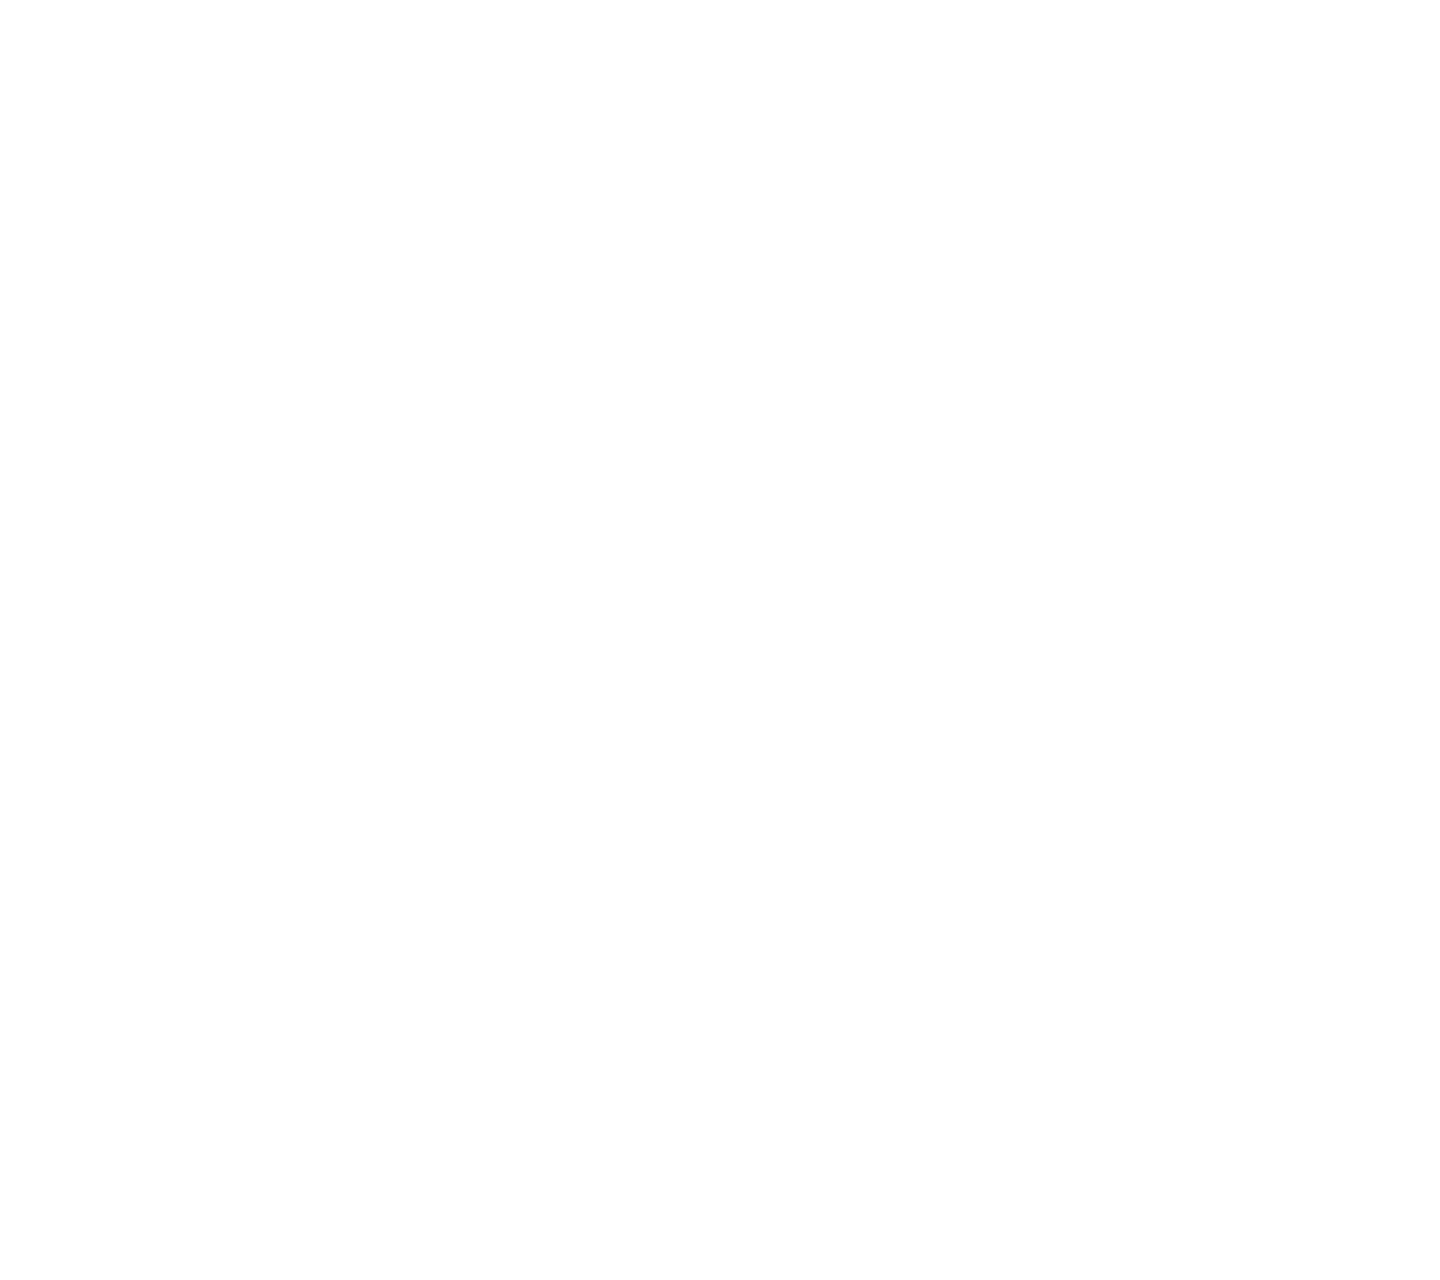

[]

In [165]:
#sns.palplot(sns.color_palette("husl", 8)) # 
index_agent = chat_df.index[chat_df['speaker'] == 'CS_Agent' ].tolist()
index_customer = chat_df.index[chat_df['speaker'] == 'Customer' ].tolist()

# fig, ax = plt.subplots()
plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(index_agent,chat_df['emotions'][index_agent],label='agent',lw=7,color='lightgreen')
plt.plot(index_customer,chat_df['emotions'][index_customer],label='customer', lw=7,color='lightblue')

plt.axvline(x=37,linewidth=10,color='r',label="Intervention")

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.,prop={'size': 30} )
plt.xlabel('Text Message Number', size=40)
plt.ylabel('Emotion',size=40)
plt.xticks(fontsize=25)
plt.yticks([0,1],labels=['Positive','Negative'],fontsize=40)

#plt.text(10.1,0,'Intervention',rotation=90)
# Changing the y-labels to "Sad" (0) and "Happy" (1)
# labels = [item.get_text() for item in ax.get_yticklabels()]
# labels[0] = 'Sad'
# labels[1] = 'Happy'

plt.savefig("Preliminary_AgentCustomer_Emotional_Output.png", bbox_inches='tight', dpi=100)
plt.plot()
#final_df.plot(x='index',y='emotions')


In [19]:
Customer_Chat = chat_df[chat_df["speaker"] == 'Customer']
CSAgent_Chat  = chat_df[chat_df["speaker"] == 'CS_Agent']
len(Customer_Chat) , len(CSAgent_Chat)

(65, 52)

<IPython.core.display.Javascript object>


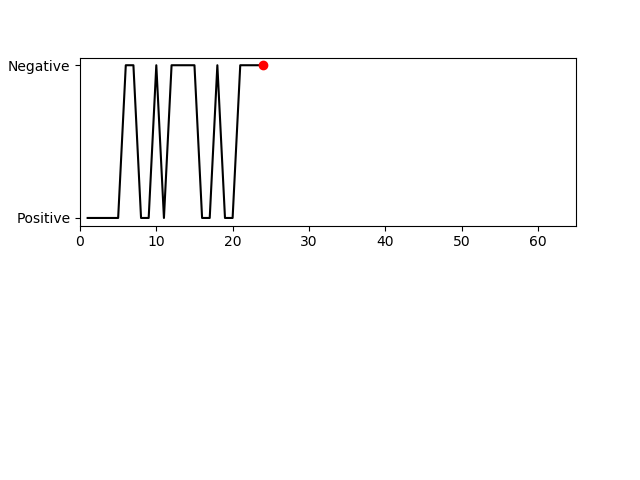

In [58]:
## Just animated 1 plot by examplining the two-graph animation code below
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
# ax2 = fig.add_subplot(2, 1, 2)

t = np.linspace(1, len(Customer_Chat), len(Customer_Chat))
x = np.array(Customer_Chat["emotions"])
#y = CSAgent_Chat["emotions"]

ax1.set_ylabel('Customer')
ax1.set_xlim(0, len(Customer_Chat))
ax1.set_ylim(-0.05, 1.05)
plt.setp(ax1.get_xticklabels(),visible=True)
plt.yticks([0,1],labels=['Positive','Negative'],fontsize=10)
# ax2.set_xlabel('t')
# ax2.set_ylabel(u'CS_Agent')
# ax2.set_xlim(0, max(chat_df.index))
# ax2.set_ylim(0, 1)

lines = []
for i in range(len(t)):    
    head = i - 1
    head_slice = (t > t[i] - 1.0) & (t < t[i])
    line1,  = ax1.plot(t[:i], x[:i], color='black')
    line1a, = ax1.plot(t[head_slice], x[head_slice], color='red', linewidth=2)
    line1e, = ax1.plot(t[head], x[head], color='red', marker='o', markeredgecolor='r')
    lines.append([line1,line1a,line1e])


# Build the animation using ArtistAnimation function

ani = animation.ArtistAnimation(fig,lines,interval=100,blit=True)

In [21]:
np.linspace(1, len(Customer_Chat), len(Customer_Chat))

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
       14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25., 26.,
       27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38., 39.,
       40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52.,
       53., 54., 55., 56., 57., 58., 59., 60., 61., 62., 63., 64., 65.])

In [23]:
## Now creating a new customer and agent conversation arrays which have the same (full conversation) index length

CSChat_Emotions = pd.DataFrame([])
CSChat_Emotions["Customer_Emotions"] = np.zeros([chat_df.shape[0]])
CSChat_Emotions["Agent_Emotions"] = np.zeros([chat_df.shape[0]])
Customer_Previous_Emotion = 0 # We presume both parties start in a positive state
CS_Agent_Previous_Emotion = 0 # ""
for i in range(chat_df.shape[0]):
    current_speaker = chat_df['speaker'].iloc[i]
    print(current_speaker)
    if current_speaker == "Customer":
        CSChat_Emotions["Customer_Emotions"].iloc[i] = chat_df['emotions'].iloc[i]
        CSChat_Emotions["Agent_Emotions"].iloc[i] = CS_Agent_Previous_Emotion
        Customer_Previous_Emotion = chat_df['emotions'].iloc[i]
    #else:
    elif current_speaker == "CS_Agent":
        CSChat_Emotions["Customer_Emotions"].iloc[i] = Customer_Previous_Emotion
        CSChat_Emotions["Agent_Emotions"].iloc[i] = chat_df['emotions'].iloc[i]
        CS_Agent_Previous_Emotion = chat_df['emotions'].iloc[i]
        


Customer
Customer
CS_Agent
Customer
Customer
Customer
CS_Agent
Customer
Customer
Customer
Customer
CS_Agent
Customer
CS_Agent
Customer
CS_Agent
CS_Agent
Customer
CS_Agent
Customer
Customer
Customer
CS_Agent
CS_Agent
Customer
CS_Agent
Customer
CS_Agent
Customer
Customer
Customer
CS_Agent
Customer
CS_Agent
CS_Agent
Customer
Customer
CS_Agent
CS_Agent
CS_Agent
Customer
CS_Agent
Customer
Customer
CS_Agent
CS_Agent
Customer
Customer
Customer
CS_Agent
Customer
CS_Agent
CS_Agent
Customer
CS_Agent
Customer
CS_Agent
Customer
Customer
CS_Agent
Customer
Customer
CS_Agent
Customer
Customer
CS_Agent
Customer
CS_Agent
Customer
CS_Agent
Customer
CS_Agent
Customer
CS_Agent
CS_Agent
Customer
Customer
CS_Agent
Customer
Customer
Customer
Customer
Customer
Customer
CS_Agent
Customer
CS_Agent
CS_Agent
CS_Agent
CS_Agent
CS_Agent
Customer
Customer
CS_Agent
Customer
Customer
CS_Agent
CS_Agent
Customer
CS_Agent
Customer
CS_Agent
Customer
CS_Agent
Customer
CS_Agent
Customer
CS_Agent
Customer
Customer
CS_Agent
C

In [24]:
t = np.linspace(0, max(CSChat_Emotions.index), max(CSChat_Emotions.index)+1)
t, t.shape, CSChat_Emotions.shape

(array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
         11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
         22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
         33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
         44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
         55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
         66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
         77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
         88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
         99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
        110., 111., 112., 113., 114., 115., 116.]), (117,), (117, 2))

In [62]:
!brew install imagemagick

/bin/sh: 1: brew: not found


<IPython.core.display.Javascript object>


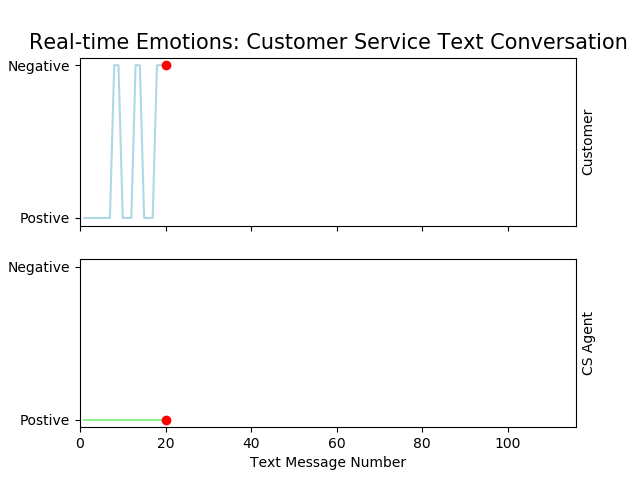

In [119]:
## Plotting both the Customer and the Agent in a single animated plot
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
#sns.palplot(sns.color_palette("husl", 8)) # 

fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

t = np.linspace(1, len(CSChat_Emotions), len(CSChat_Emotions))
x = CSChat_Emotions["Customer_Emotions"]
y = CSChat_Emotions["Agent_Emotions"]
# print(t.shape)
# print(x.shape)
# print(y.shape)

ax1.set_ylabel(u'Customer')
ax1.yaxis.set_label_position("right")
ax1.set_xlim(0, max(CSChat_Emotions.index))
ax1.set_ylim(-0.05, 1.05)
plt.setp(ax1.get_xticklabels(),visible=False)
ax1.set_yticks([0, 1])
ax1.set_yticklabels(labels=['Postive', 'Negative'])
ax1.set_title('Real-time Emotions: Customer Service Text Conversation', size=15)

ax2.set_xlabel('Text Message Number')
ax2.set_ylabel(u'CS Agent')
ax2.yaxis.set_label_position("right")
ax2.set_xlim(0, max(CSChat_Emotions.index))
ax2.set_ylim(-0.05, 1.05)
ax2.set_yticks([0, 1])
ax2.set_yticklabels(labels=['Postive', 'Negative'])

lines = []
for i in range(1,len(t)): 
#     print(i)
    head = i - 1
    head_slice = (t > t[i] - 1.0) & (t < t[i])
    line1,  = ax1.plot(t[:i], x[:i], color='lightblue')
    line1a, = ax1.plot(t[head_slice], x[head_slice], color='red', linewidth=2)
    line1e, = ax1.plot(t[head], x[head], color='red', marker='o', markeredgecolor='r')
    line2,  = ax2.plot(t[:i], y[:i], color='lightgreen')
    line2a, = ax2.plot(t[head_slice], y[head_slice], color='red', linewidth=2)
    line2e, = ax2.plot(t[head], y[head], color='red', marker='o', markeredgecolor='r')
    lines.append([line1,line1a,line1e,line2,line2a,line2e])


# Build the animation using ArtistAnimation function

ani = animation.ArtistAnimation(fig,lines,interval=125,blit=True)
ani.save('animation.gif', writer='imagemagick', fps=10)

In [64]:
os.getcwd()

'/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/data/raw'

In [38]:
#max(CSChat_Emotions.index)
# line1a, = ax1.plot(t[head_slice], x[head_slice], color='red', linewidth=2)
# line1e, = ax1.plot(t[head], x[head], color='red', marker='o', markeredgecolor='r')
# head, t
t = np.linspace(1, len(CSChat_Emotions), len(CSChat_Emotions))
print(t)
for i in t:
    print(i)

[  1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.  14.
  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  27.  28.
  29.  30.  31.  32.  33.  34.  35.  36.  37.  38.  39.  40.  41.  42.
  43.  44.  45.  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.
  57.  58.  59.  60.  61.  62.  63.  64.  65.  66.  67.  68.  69.  70.
  71.  72.  73.  74.  75.  76.  77.  78.  79.  80.  81.  82.  83.  84.
  85.  86.  87.  88.  89.  90.  91.  92.  93.  94.  95.  96.  97.  98.
  99. 100. 101. 102. 103. 104. 105. 106. 107. 108. 109. 110. 111. 112.
 113. 114. 115. 116. 117.]
1.0
2.0
3.0
4.0
5.0
6.0
7.0
8.0
9.0
10.0
11.0
12.0
13.0
14.0
15.0
16.0
17.0
18.0
19.0
20.0
21.0
22.0
23.0
24.0
25.0
26.0
27.0
28.0
29.0
30.0
31.0
32.0
33.0
34.0
35.0
36.0
37.0
38.0
39.0
40.0
41.0
42.0
43.0
44.0
45.0
46.0
47.0
48.0
49.0
50.0
51.0
52.0
53.0
54.0
55.0
56.0
57.0
58.0
59.0
60.0
61.0
62.0
63.0
64.0
65.0
66.0
67.0
68.0
69.0
70.0
71.0
72.0
73.0
74.0
75.0
76.0
77.0
78.0
79.0
80.0
81.0
82.0
83.0

In [ ]:
## Chat Text Gif Creation
for i in range(len(chat_df))

In [ ]:
for i in range(real_conv.shape[0]):
    if real_conv.iloc[i].split(':')[0] == 'Customer':
        print(TBLUE + 'Text Number = ' + str(i) + ' | ' + real_conv.iloc[i])
        print("---------------")
    else:
        print(TGREEN + 'Text Number = ' + str(i) + ' | ' + real_conv.iloc[i])
        print("---------------")

In [166]:
TGREEN =  '\033[32m' # Green Text
#print (TGREEN + "This is some green text!")
TBLUE = '\033[34m' # Blue Text
#print (TBLUE + "This is some blue text!")

def PrintingCSConvo(file):
    """
    Print the customer service conversation with the customer and agent highlighted n different colors
    Customer highlighted in blue
    Agent highlight in Green
    Input: Text file properly formated "Customer/Agent/ .......text........"
    Output: Prints each text with the text number, customer/agent label, and the text cwhich they wrote
    """

    for i in range(file.shape[0]):
        if file.iloc[i].split(':')[0] == 'Customer':
            print(TBLUE + 'Text Number = ' + str(i) + ' | ' + file.iloc[i])
            print("---------------")
        else:
            print(TGREEN + 'Text Number = ' + str(i) + ' | ' + file.iloc[i])
            print("---------------")

PrintingCSConvo(real_conv)            

Text Number = 0 | Customer: Hi CS_Agent:, I wanted to check up on the status of my booking
---------------
Text Number = 1 | Customer: The Reference is ZZZZZZZ
---------------
Text Number = 2 | CS_Agent: Sure. I can definitely help you with that.
---------------
Text Number = 3 | Customer: It's a trip to the US and I had to fill in an APIS
---------------
Text Number = 4 | Customer: However, the final destination is ZZZZZZZ
---------------
Text Number = 5 | Customer: and I do not seem to be seeing the Canadian flights
---------------
Text Number = 6 | CS_Agent: Can you please provide your full name and flight details (date of travel and destination)?
---------------
Text Number = 7 | Customer: XXXXX, flight departure is on the ZZth ZZZ at ZZ:ZZ
---------------
Text Number = 8 | Customer: Then the flight from ZZ to XXXXX
---------------
Text Number = 9 | Customer: The return flight is on the ZZth ZZZZ from XXXXX to ZZZZZZZZ
---------------
Text Number = 10 | Customer: and then returning

In [169]:
## From: https://github.com/pimoroni/scroll-phat-hd/blob/master/examples/advanced-scrolling.py

#!/usr/bin/env python

import time

import scrollphathd

print("""
Scroll pHAT HD: Advanced Scrolling
Advanced scrolling example which displays a message line-by-line
and then skips back to the beginning.
Press Ctrl+C to exit.
""")

# Uncomment the below if your display is upside down
#   (e.g. if you're using it in a Pimoroni Scroll Bot)
# scrollphathd.rotate(degrees=180)

# Dial down the brightness
scrollphathd.set_brightness(0.2)

# If rewind is True the scroll effect will rapidly rewind after the last line
rewind = True

# Delay is the time (in seconds) between each pixel scrolled
delay = 0.03

# Change the lines below to your own message
lines = ["In the old #BILGETANK we'll keep you in the know",
         "In the old #BILGETANK we'll fix your techie woes",
         "And we'll make things",
         "And we'll break things",
         "'til we're altogether aching",
         "Then we'll grab a cup of grog down in the old #BILGETANK"]

# Determine how far apart each line should be spaced vertically
line_height = scrollphathd.DISPLAY_HEIGHT + 2

# Store the left offset for each subsequent line (starts at the end of the last line)
offset_left = 0

# Draw each line in lines to the Scroll pHAT HD buffer
# scrollphathd.write_string returns the length of the written string in pixels
# we can use this length to calculate the offset of the next line
# and will also use it later for the scrolling effect.
lengths = [0] * len(lines)

for line, text in enumerate(lines):
    lengths[line] = scrollphathd.write_string(text, x=offset_left, y=line_height * line)
    offset_left += lengths[line]

# This adds a little bit of horizontal/vertical padding into the buffer at
# the very bottom right of the last line to keep things wrapping nicely.
scrollphathd.set_pixel(offset_left - 1, (len(lines) * line_height) - 1, 0)

while True:
    # Reset the animation
    scrollphathd.scroll_to(0, 0)
    scrollphathd.show()

    # Keep track of the X and Y position for the rewind effect
    pos_x = 0
    pos_y = 0

    for current_line, line_length in enumerate(lengths):
        # Delay a slightly longer time at the start of each line
        time.sleep(delay * 10)

        # Scroll to the end of the current line
        for y in range(line_length):
            scrollphathd.scroll(1, 0)
            pos_x += 1
            time.sleep(delay)
            scrollphathd.show()

        # If we're currently on the very last line and rewind is True
        # We should rapidly scroll back to the first line.
        if current_line == len(lines) - 1 and rewind:
            for y in range(pos_y):
                scrollphathd.scroll(-int(pos_x / pos_y), -1)
                scrollphathd.show()
                time.sleep(delay)

        # Otherwise, progress to the next line by scrolling upwards
        else:
            for x in range(line_height):
                scrollphathd.scroll(0, 1)
                pos_y += 1
                scrollphathd.show()
                time.sleep(delay)
# © 2020 GitHub, Inc.
# Terms
# Privacy
# Security
# Status
# Help
# Contact GitHub
# Pricing
# API
# Training
# Blog
# About


ModuleNotFoundError: No module named 'scrollphathd'

In [167]:
from PIL import Image, ImageDraw
 
img = Image.new('RGB', (100, 30), color = (73, 109, 137))
 
d = ImageDraw.Draw(img)
d.text((10,10), "Hello World", fill=(255,255,0))



In [155]:
import tkinter as tk

root = tk.Tk()
deli = 100           # milliseconds of delay per character
svar = tk.StringVar()
labl = tk.Label(root, textvariable=svar, height=10 )

def shif():
    shif.msg = shif.msg[1:] + shif.msg[0]
    svar.set(shif.msg)
    root.after(deli, shif)

shif.msg = ' Is this an alert, or what? '
shif()
labl.pack()
root.mainloop()

# Customer Support on Twitter

In [ ]:
## Importing the "Customer Support on Twitter"
os.chdir('/home/george/Documents/Insight_DS_TO20A/Projects/EmotionalDetection/data/raw/CustomerSupportTwitter')
cst_orig = pd.read_csv('twcs.csv')
print(cst_orig.shape)
cst_orig.dropna(inplace=True) # removing the NaN valued rows as we desire a conversation (3 tweets)
                              # which requires all tweet_id place holders to be non-empty
print(cst_orig.shape)

In [ ]:
cst_orig.columns, cst_orig.shape

In [ ]:
# Now parsing the response_tweet_id and in_reponse_to_tweet_idt
#print(type(cst_orig['response_tweet_id']))
#print(np.fromstring(cst_orig['response_tweet_id'][5], dtype=int, sep=','))

cst_orig_np = cst_orig['response_tweet_id'].to_numpy()

# type(str.split(cst_orig_np[5],','))
# int(str.split(cst_orig_np[5],',')[0])

# list(map(int, cst_orig_np))
print((cst_orig['response_tweet_id'].iloc[5]))
# list(map(int,cst_orig_np[5]))

In [ ]:
## identifying conversations -- gathering the unqiue pairs of tweets
tweetID_pairs = pd.DataFrame([])
tweetID_pairs['author_id'] = cst_orig['author_id']
tweetID_pairs['response_tweet_id'] = cst_orig['response_tweet_id']
print("The length of original tweet id-pair dataframe is:", tweetID_pairs.shape[0])

# Generate a numpy array to sort the rows
tweetID_pairs_np = tweetID_pairs.to_numpy(copy=True)
tweetID_pairs_np = np.sort(tweetID_pairs_np)

tweetID_pairsSrtd = pd.DataFrame([])
tweetID_pairsSrtd['ID1'] = tweetID_pairs_np[:,0]
tweetID_pairsSrtd['ID2'] = tweetID_pairs_np[:,1]
tweetID_pairsSrtd.drop_duplicates(inplace=True)
print("The length of the unique tweet pair", tweetID_pairsSrtd.shape[0])

In [ ]:
tweetID_pairsSrtd['ID1'].unique().shape, tweetID_pairsSrtd['ID2'].unique().shape

In [ ]:
## Connecting twiter conversations together through 'tweet_id', 'response_tweet_id', 'in_response_to_tweet_id'
convos = pd.DataFrame([])

for i in range(cst_orig.shape[0]):
    convos["BaseID"].iloc[i] = cst_orig['tweet_id']
    response_temp = cst_orig['response_tweet_id']
    resp_list = 

## -----------------------The Test Dev. Case is Completed ---------------------------------

# ------------------------------------------------------------------------------------

# APPENDIX: The Individual Functions and Examples cases to showcase how they work


In [ ]:
## Punctuation Removal
def form_sentence(headline):
    headline_blob = TextBlob(headline)
    return ' '.join(headline_blob.words)

data_temp['HL_PuncRem_1'] = 'NaN'
for i in range(data_temp.shape[0]):
    data_temp.HL_PuncRem_1.iloc[i] = form_sentence(data_temp['headline'].iloc[i])
    
    

In [ ]:
## Removing Stop-Words (e.g: is, are, have)
def no_user_alpha(headline):
    headline_list = [ele for ele in headline.split() if ele != 'user']
    clean_tokens = [t for t in headline_list if re.match(r'[^\W\d]*$', t)]
    clean_s = ' '.join(clean_tokens)
    clean_mess = [word for word in clean_s.split() if word.lower() not in stopwords.words('english')]
    return clean_mess

data_temp['HL_StopWords_2'] = 'NaN'
for i in range(data_temp.shape[0]):
    data_temp.HL_StopWords_2.iloc[i] = no_user_alpha(data_temp['HL_PuncRem_1'].iloc[i])


In [ ]:
print(data_temp.HL_StopWords_2.iloc[0])
print(data_temp.headline.iloc[0])

In [ ]:
# Normalize Text -- NLTK’s built-in WordNetLemmatizer does this 
def normalization(headline_list):
        lem = WordNetLemmatizer()
        normalized_headline = []
        for word in headline_list:
            normalized_text = lem.lemmatize(word,'v')
            normalized_headline.append(normalized_text)
        return normalized_headline
    
data_temp['HL_Normalize_3'] = 'NaN'
for i in range(data_temp.shape[0]):
    data_temp.HL_Normalize_3.iloc[i] = normalization(data_temp['HL_StopWords_2'].iloc[i])
    

In [ ]:
print(data_temp.HL_Normalize_3.iloc[0])
print(data_temp.headline.iloc[0])

<IPython.core.display.Javascript object>


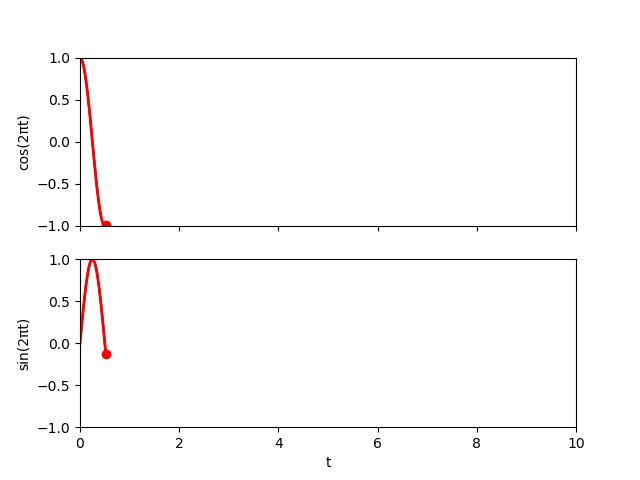

In [26]:
fig = plt.figure()
ax1 = fig.add_subplot(2, 1, 1)
ax2 = fig.add_subplot(2, 1, 2)

t = np.linspace(0, 10, 500)
x = np.cos(2 * np.pi * t)
y = np.sin(2 * np.pi * t)


ax1.set_ylabel(u'cos(2\u03c0t)')
ax1.set_xlim(0, 10)
ax1.set_ylim(-1, 1)
plt.setp(ax1.get_xticklabels(),visible=False)

ax2.set_xlabel('t')
ax2.set_ylabel(u'sin(2\u03c0t)')
ax2.set_xlim(0, 10)
ax2.set_ylim(-1, 1)

lines = []
for i in range(len(t)):
    head = i - 1
    head_slice = (t > t[i] - 1.0) & (t < t[i])
    line1,  = ax1.plot(t[:i], x[:i], color='black')
    line1a, = ax1.plot(t[head_slice], x[head_slice], color='red', linewidth=2)
    line1e, = ax1.plot(t[head], x[head], color='red', marker='o', markeredgecolor='r')
    line2,  = ax2.plot(t[:i], y[:i], color='black')
    line2a, = ax2.plot(t[head_slice], y[head_slice], color='red', linewidth=2)
    line2e, = ax2.plot(t[head], y[head], color='red', marker='o', markeredgecolor='r')
    lines.append([line1,line1a,line1e,line2,line2a,line2e])


# Build the animation using ArtistAnimation function

ani = animation.ArtistAnimation(fig,lines,interval=50,blit=True)